In [1]:
import os
import glob
import math

import numpy as np
import pandas as pd

In [2]:
paths = glob.glob('collin_data/*')
paths

['collin_data/2020-04-21_08:22:02_6.csv',
 'collin_data/2020-04-21_09:30:18_A.csv',
 'collin_data/2020-04-21_09:16:32_A.csv',
 'collin_data/2020-04-21_07:56:37_1.csv',
 'collin_data/2020-04-21_08:34:56_9.csv',
 'collin_data/2020-04-21_08:35:13_9.csv',
 'collin_data/2020-04-21_09:27:42_A.csv',
 'collin_data/2020-04-21_09:11:37_A.csv',
 'collin_data/2020-04-21_08:08:16_3.csv',
 'collin_data/2020-04-21_08:25:23_7.csv',
 'collin_data/2020-04-21_08:02:29_2.csv',
 'collin_data/2020-04-21_09:25:08_A.csv',
 'collin_data/2020-04-21_08:01:19_2.csv',
 'collin_data/2020-04-21_09:26:40_A.csv',
 'collin_data/2020-04-21_09:17:14_A.csv',
 'collin_data/2020-04-21_08:48:22_12.csv',
 'collin_data/2020-04-21_09:17:30_A.csv',
 'collin_data/2020-04-21_08:11:59_4.csv',
 'collin_data/2020-04-21_08:59:13_14.csv',
 'collin_data/2020-04-21_09:04:13_15.csv',
 'collin_data/2020-04-21_08:15:16_5.csv',
 'collin_data/2020-04-21_08:15:53_5.csv',
 'collin_data/2020-04-21_09:29:14_A.csv',
 'collin_data/2020-04-21_08:42:

In [3]:
def initializeDf(path):
    
    df = pd.read_csv(path).reset_index()
    df.drop(" pill_count", axis=1, inplace=True)
    return df

In [4]:
def getMetaInfo(path):
    
    pill_count = path.split("_")[-1].split(".")[0]
    if pill_count == "A": pill_count = np.nan
    else: pill_count = int(pill_count)
    
    meta_df = pd.DataFrame(data={"pill_count":[pill_count]})
    meta_df["pills_low"] = (meta_df["pill_count"] <= 10).astype(int)
    
    if type(pill_count) == int:
        meta_df["activity"] = "pill"
    else:
        meta_df["activity"] = "other"
        meta_df["pills_low"] = np.nan
        
    return meta_df

In [5]:
def renameColumns(df):
        
    df.columns = ['loggingSample',
                   'accel_x',
                   'accel_y',
                   'accel_z',
                   'gyro_x',
                   'gyro_y',
                   'gyro_z']
    return df

In [6]:
def trimData(df, trim_start_pct, trim_end_pct):
    
    count = df.shape[0]
    new_start = math.floor(count * trim_start_pct)
    new_end = math.ceil(count * (1 - trim_end_pct))
    
    return df[new_start:new_end]

In [7]:
def windowData(df, n_windows):
    
    df["window"] = pd.qcut(df["loggingSample"], 
                           n_windows, 
                           range(1,n_windows+1))
    
    return df

In [8]:
def pivotData(df):
    
    df = df.groupby('window')[["gyro_x", "gyro_y", "gyro_z", 
                    "accel_x", "accel_y", "accel_z"]]\
                    .agg(["median", "min", "max", "std"])
    
    df.columns = ["_".join(col).strip() for col in df.columns.values]
    df["temp"] = None
    df = df.reset_index()
    
    df = df.pivot("temp", "window").reset_index(drop=True)
    df.columns = [col[0] + "_" + str(col[1]) for col in df.columns.values]
    
    return df

In [9]:
def processFile(path):
    
    meta_df = getMetaInfo(path)        

    df = initializeDf(path)        
    df = renameColumns(df)
    
    if meta_df["activity"][0] == "other":
        df["gyro_z"] = df["gyro_z"].apply(lambda x: float(x[:-1]))

    
    df = trimData(df, trim_start_pct=0.05, trim_end_pct=0.05)
    df = windowData(df, n_windows=5)
    df = pivotData(df)
    
    
    return pd.concat([df, meta_df], axis=1)

In [10]:
processed_df = pd.DataFrame()

for i, path in enumerate(paths):
    df_ = processFile(path)
    processed_df = pd.concat([processed_df, df_ ])

In [11]:
processed_df.reset_index(drop=True).head(1)

,gyro_x_median_1,gyro_x_median_2,gyro_x_median_3,gyro_x_median_4,gyro_x_median_5,gyro_x_min_1,gyro_x_min_2,gyro_x_min_3,gyro_x_min_4,gyro_x_min_5,...,accel_z_max_4,accel_z_max_5,accel_z_std_1,accel_z_std_2,accel_z_std_3,accel_z_std_4,accel_z_std_5,pill_count,pills_low,activity
0,-0.367935,-0.074074,0.043672,0.232942,0.527233,-11.518023,-12.162574,-0.59567,-2.333485,-1.492186,...,0.512223,0.131544,0.173853,0.101226,0.198305,0.24711,0.062755,6.0,1.0,pill


In [12]:
processed_df = processed_df.reset_index(drop=True)

In [13]:
assert processed_df.drop(["pill_count","pills_low","activity"], axis=1).isna().values.any() == False

In [14]:
processed_df

,gyro_x_median_1,gyro_x_median_2,gyro_x_median_3,gyro_x_median_4,gyro_x_median_5,gyro_x_min_1,gyro_x_min_2,gyro_x_min_3,gyro_x_min_4,gyro_x_min_5,...,accel_z_max_4,accel_z_max_5,accel_z_std_1,accel_z_std_2,accel_z_std_3,accel_z_std_4,accel_z_std_5,pill_count,pills_low,activity
0,-0.367935,-0.074074,0.043672,0.232942,0.527233,-11.518023,-12.162574,-0.595670,-2.333485,-1.492186,...,0.512223,0.131544,0.173853,0.101226,0.198305,0.247110,0.062755,6.0,1.0,pill
1,0.004561,0.004920,0.004185,0.002851,0.003876,-0.011572,-0.019182,-0.005499,-0.007010,-0.048374,...,0.004675,0.004740,0.001196,0.001299,0.000991,0.001201,0.001521,NaN,NaN,other
2,-0.000356,-0.000974,-0.001491,-0.002749,0.000840,-0.063841,-0.010988,-0.014018,-0.012494,-0.024369,...,0.005652,0.010302,0.003826,0.001059,0.001365,0.001158,0.002209,NaN,NaN,other
3,-0.233266,-0.005641,1.015926,-0.515116,0.093410,-2.617697,-10.054420,-2.838974,-3.884917,-0.249898,...,0.227304,0.208025,0.187443,0.211181,0.208041,0.070130,0.067465,1.0,1.0,pill
4,-0.554068,-0.236736,1.485785,-0.323291,0.579958,-4.953338,-11.776284,0.217840,-2.587376,-0.235746,...,0.265844,0.151806,0.163725,0.106234,0.158480,0.112807,0.054894,9.0,1.0,pill
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,0.003332,-0.001874,-0.000918,0.000777,-0.004130,-0.021424,-0.015726,-0.016008,-0.018458,-0.050326,...,0.004462,0.018512,0.001399,0.001169,0.001201,0.001181,0.003035,NaN,NaN,other
211,-0.280273,-0.314979,0.675794,-0.180135,0.163862,-2.518000,-10.336287,-0.267164,-2.809045,-1.331136,...,0.199607,0.103696,0.179829,0.172772,0.132402,0.174332,0.055122,13.0,0.0,pill
212,-0.342428,-0.663958,1.182321,0.629328,0.018379,-3.538319,-10.908702,-0.482931,-4.496098,-6.702565,...,0.127886,0.311013,0.252768,0.174930,0.217101,0.073176,0.089824,2.0,1.0,pill
213,0.000144,-0.001348,-0.001612,-0.000340,0.000059,-0.023678,-0.027025,-0.013416,-0.017935,-0.016771,...,0.005629,0.014098,0.001525,0.001496,0.001070,0.001188,0.002278,NaN,NaN,other


----
# Exploratory Modeling

In [15]:
import math

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

### Scaling 

In [16]:
ss = StandardScaler()

In [17]:
processed_df["pill_count"].value_counts()

8.0     10
10.0    10
13.0    10
11.0    10
5.0     10
15.0    10
14.0    10
4.0     10
12.0    10
2.0     10
7.0     10
3.0     10
9.0     10
1.0     10
6.0     10
Name: pill_count, dtype: int64

### Regression

In [18]:
processed_df_reg = processed_df.loc[~processed_df.pill_count.isna()]
processed_df_reg

,gyro_x_median_1,gyro_x_median_2,gyro_x_median_3,gyro_x_median_4,gyro_x_median_5,gyro_x_min_1,gyro_x_min_2,gyro_x_min_3,gyro_x_min_4,gyro_x_min_5,...,accel_z_max_4,accel_z_max_5,accel_z_std_1,accel_z_std_2,accel_z_std_3,accel_z_std_4,accel_z_std_5,pill_count,pills_low,activity
0,-0.367935,-0.074074,0.043672,0.232942,0.527233,-11.518023,-12.162574,-0.595670,-2.333485,-1.492186,...,0.512223,0.131544,0.173853,0.101226,0.198305,0.247110,0.062755,6.0,1.0,pill
3,-0.233266,-0.005641,1.015926,-0.515116,0.093410,-2.617697,-10.054420,-2.838974,-3.884917,-0.249898,...,0.227304,0.208025,0.187443,0.211181,0.208041,0.070130,0.067465,1.0,1.0,pill
4,-0.554068,-0.236736,1.485785,-0.323291,0.579958,-4.953338,-11.776284,0.217840,-2.587376,-0.235746,...,0.265844,0.151806,0.163725,0.106234,0.158480,0.112807,0.054894,9.0,1.0,pill
5,-0.173755,-0.117661,1.429057,-0.273822,0.638555,-5.859836,-10.901626,-0.203829,-1.994986,-0.036500,...,0.253822,0.111044,0.235336,0.209178,0.129835,0.132793,0.046530,9.0,1.0,pill
8,-0.303467,-0.192580,0.064904,0.278077,0.218809,-2.886006,-10.914850,-0.255372,-2.978877,-1.057929,...,0.216209,0.219264,0.106576,0.118045,0.146715,0.103779,0.074444,3.0,1.0,pill
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,-0.176335,-0.145327,0.215947,-0.136826,0.542623,-3.217016,-12.030450,-0.332189,-2.806397,-0.409238,...,0.254120,0.110802,0.185588,0.180482,0.174955,0.125244,0.050065,6.0,1.0,pill
209,-0.317895,-0.204468,0.532504,0.241862,0.200731,-4.743906,-10.060389,-0.194610,-2.731018,-1.151409,...,0.289740,0.134189,0.219623,0.148236,0.125828,0.159148,0.052309,14.0,0.0,pill
211,-0.280273,-0.314979,0.675794,-0.180135,0.163862,-2.518000,-10.336287,-0.267164,-2.809045,-1.331136,...,0.199607,0.103696,0.179829,0.172772,0.132402,0.174332,0.055122,13.0,0.0,pill
212,-0.342428,-0.663958,1.182321,0.629328,0.018379,-3.538319,-10.908702,-0.482931,-4.496098,-6.702565,...,0.127886,0.311013,0.252768,0.174930,0.217101,0.073176,0.089824,2.0,1.0,pill


In [19]:
X = processed_df_reg.drop(["pill_count", "pills_low", "activity"], axis=1).to_numpy()
X = ss.fit_transform(X)

y = processed_df_reg[["pill_count"]].to_numpy()

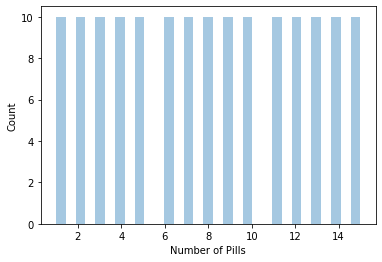

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.xlabel("Number of Pills")
plt.ylabel("Count")
sns.distplot(y, hist=True, kde=False, bins=31)
plt.show()

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

### Tree Based Regression

In [22]:
# XGB Regressor
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, n_estimators=150)
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_train, y_train)

0.9999757676249538

In [23]:
median_absolute_error(xgb_reg.predict(X_train), y_train)

0.01307058334350586

In [24]:
# Much worse on the val data 
xgb_reg.score(X_val, y_val)

0.7937600295705209

In [25]:
y_pred = xgb_reg.predict(X_val)
y_pred[:50]

array([ 3.6680865,  8.127433 , 12.636044 ,  6.364836 ,  7.5458436,
        6.229485 , 11.294411 , 12.089233 ,  8.798457 , 12.318484 ,
        3.6231644,  4.4016867, 13.499495 ,  5.9232154,  8.200504 ,
       12.454609 , 11.396478 ,  3.7832382,  7.151154 ,  8.646724 ,
       14.136813 ,  7.495645 , 13.816497 ,  7.1959214,  9.009367 ,
        8.314953 , 10.535794 ,  7.161952 ,  2.4158254,  3.901614 ],
      dtype=float32)

In [26]:
y_val[:50].reshape([-1])

array([ 4.,  6., 15.,  5., 10.,  9., 15., 11.,  7., 12.,  3.,  5., 14.,
        4.,  7., 14., 11.,  1., 10., 13., 14.,  8., 13.,  6.,  7.,  6.,
       10.,  7.,  2.,  1.])

In [27]:
r2_score(y_val, y_pred)

0.7937600295705209

In [28]:
median_absolute_error(y_val, y_pred)

1.282670259475708

In [29]:
mean_absolute_error(y_val, y_pred)

1.5363532781600953

### Feature Importance

<Figure size 1440x720 with 0 Axes>

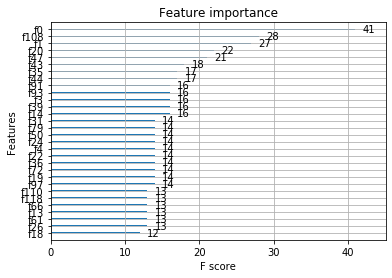

In [30]:
plt.figure(figsize=(20,10))
xgb.plot_importance(xgb_reg, max_num_features=30)

In [31]:
sorted(list(zip(processed_df_reg.drop(["pill_count", "pills_low", "activity"], axis=1).columns,
         xgb_reg.feature_importances_)), key=lambda x: x[1], reverse=True)

[('accel_x_max_3', 0.31267488),
 ('accel_y_std_3', 0.13562506),
 ('accel_x_std_3', 0.07795378),
 ('gyro_z_max_4', 0.045513704),
 ('gyro_z_std_4', 0.04115245),
 ('gyro_y_std_1', 0.038967475),
 ('gyro_x_max_5', 0.037232377),
 ('gyro_y_min_2', 0.029417543),
 ('gyro_y_median_2', 0.029116346),
 ('gyro_z_min_3', 0.027039882),
 ('gyro_y_min_3', 0.018214935),
 ('gyro_x_min_2', 0.01761645),
 ('accel_z_std_1', 0.01516513),
 ('gyro_x_std_3', 0.013952189),
 ('gyro_z_median_2', 0.013309225),
 ('gyro_y_max_1', 0.008976798),
 ('gyro_y_min_5', 0.008781866),
 ('accel_z_min_4', 0.0071097095),
 ('gyro_z_median_5', 0.007065165),
 ('gyro_y_std_5', 0.006863867),
 ('gyro_y_median_1', 0.006692111),
 ('accel_x_std_4', 0.006553136),
 ('gyro_z_min_2', 0.005617425),
 ('gyro_x_std_5', 0.005615172),
 ('gyro_x_max_2', 0.005024202),
 ('gyro_z_min_1', 0.0045566023),
 ('gyro_y_median_3', 0.0042933384),
 ('accel_z_max_3', 0.0035307948),
 ('gyro_y_median_5', 0.00318374),
 ('gyro_y_max_3', 0.0030792458),
 ('gyro_y_std_2',

In [32]:
xgb_reg.feature_importances_[:10]

array([0.00016818, 0.00122654, 0.00022407, 0.0002553 , 0.00257948,
       0.00133229, 0.01761645, 0.00069548, 0.00147036, 0.0001288 ],
      dtype=float32)

In [33]:
from sklearn.feature_selection import SelectFromModel

features, scores, med_errors, mean_errors = [], [], [], []

thresholds = sorted(xgb_reg.feature_importances_, reverse=True)[:100]
#print(thresholds)
for thresh in thresholds:
    selection = SelectFromModel(xgb_reg, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    n = select_X_train.shape[1]
    features += [n]
    
    selection_model = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, n_estimators=100)
    selection_model.fit(select_X_train, y_train)
    
    select_X_val = selection.transform(X_val)
    y_pred = selection_model.predict(select_X_val)
    
    r2 = r2_score(y_val, y_pred)
    scores += [r2]
    
    mae = median_absolute_error(y_val, y_pred)
    med_errors += [mae]
    
    mean_error = mean_absolute_error(y_val, y_pred)
    mean_errors += [mean_error]
    
    print(f'Thresh={thresh:.3f}, n={n}, R2: {r2:.2f}, MAE: {mae:.1f}, MeanAE: {mean_error:.1f}')

Thresh=0.313, n=1, R2: 0.22, MAE: 2.0, MeanAE: 2.9
Thresh=0.136, n=2, R2: 0.36, MAE: 1.8, MeanAE: 2.7
Thresh=0.078, n=3, R2: 0.47, MAE: 1.8, MeanAE: 2.4
Thresh=0.046, n=4, R2: 0.48, MAE: 1.9, MeanAE: 2.4
Thresh=0.041, n=5, R2: 0.52, MAE: 1.6, MeanAE: 2.2
Thresh=0.039, n=6, R2: 0.74, MAE: 1.4, MeanAE: 1.7
Thresh=0.037, n=7, R2: 0.72, MAE: 1.6, MeanAE: 1.8
Thresh=0.029, n=8, R2: 0.76, MAE: 1.4, MeanAE: 1.6
Thresh=0.029, n=9, R2: 0.78, MAE: 1.2, MeanAE: 1.6
Thresh=0.027, n=10, R2: 0.86, MAE: 0.9, MeanAE: 1.2
Thresh=0.018, n=11, R2: 0.83, MAE: 1.2, MeanAE: 1.4
Thresh=0.018, n=12, R2: 0.84, MAE: 1.1, MeanAE: 1.3
Thresh=0.015, n=13, R2: 0.82, MAE: 1.1, MeanAE: 1.4
Thresh=0.014, n=14, R2: 0.80, MAE: 1.1, MeanAE: 1.4
Thresh=0.013, n=15, R2: 0.80, MAE: 1.1, MeanAE: 1.5
Thresh=0.009, n=16, R2: 0.80, MAE: 1.2, MeanAE: 1.5
Thresh=0.009, n=17, R2: 0.77, MAE: 1.2, MeanAE: 1.5
Thresh=0.007, n=18, R2: 0.77, MAE: 1.4, MeanAE: 1.6
Thresh=0.007, n=19, R2: 0.79, MAE: 1.2, MeanAE: 1.6
Thresh=0.007, n=20, R

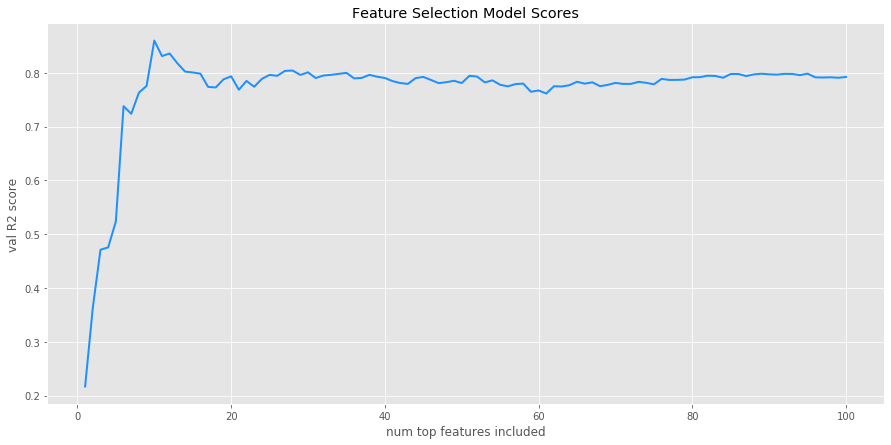

In [34]:
plt.style.use('ggplot')
plt.figure(figsize=(15,7))
plt.plot(features, scores, linewidth=2, color="dodgerblue")
plt.xlabel("num top features included")
plt.ylabel("val R2 score")
plt.title("Feature Selection Model Scores")
plt.show()

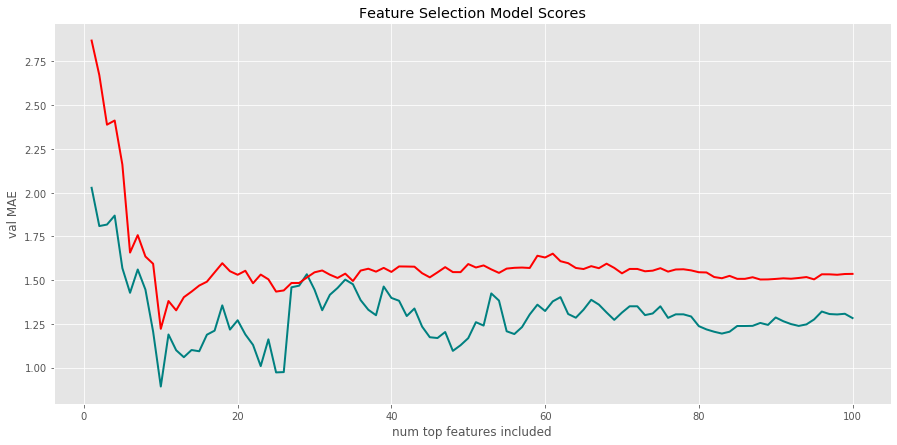

In [35]:
plt.style.use('ggplot')
plt.figure(figsize=(15,7))
plt.plot(features, med_errors, linewidth=2, color="teal")
plt.plot(features, mean_errors, linewidth=2, color="red")
plt.xlabel("num top features included")
plt.ylabel("val MAE")
plt.title("Feature Selection Model Scores")
plt.show()

### Selecting the Best Model

In [36]:
selection = SelectFromModel(xgb_reg, threshold=thresholds[9], prefit=True)
select_X_train = selection.transform(X_train)

selection_model = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, n_estimators=100)
selection_model.fit(select_X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [37]:
select_X_val = selection.transform(X_val)
y_pred = selection_model.predict(select_X_val)
    
r2_score(y_val, y_pred)

0.859760180539099

In [38]:
median_absolute_error(y_val, y_pred)

0.8914990425109863

In [39]:
mean_absolute_error(y_val, y_pred)

1.2212233583132426

In [40]:
# on all data
select_X_all = selection.transform(X)
select_X_all.shape

(150, 10)

In [41]:
selection_model.fit(select_X_all, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [42]:
y_pred_all = selection_model.predict(select_X_all)

r2_score(y, y_pred_all), median_absolute_error(y, y_pred_all), mean_absolute_error(y, y_pred_all)

(0.9926141930534922, 0.20571792125701904, 0.27212159911791484)

### Parameter Tuning

In [43]:
from sklearn.model_selection import RandomizedSearchCV

params = {
 'max_depth':[2, 3, 4],
 'min_child_weight':[1, 2, 3],
 'reg_alpha':[0, 0.1, 0.2, 0.3],
}

searchCV = RandomizedSearchCV(estimator=selection_model,
                                 param_distributions=params, 
                                 n_iter=50,
                                 cv=3,
                                 verbose=1,
                                 n_jobs=-1,)

searchCV.fit(select_X_all, y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/kevin/opt/anaconda3/envs/DistributedComputing/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                           

In [44]:
searchCV.best_params_, searchCV.best_score_

({'reg_alpha': 0.1, 'min_child_weight': 2, 'max_depth': 2}, 0.7750643884711909)

In [45]:
y_pred = searchCV.predict(select_X_all)
y_pred

array([ 7.5830574,  1.2229048,  9.342248 ,  8.166186 ,  3.204576 ,
        7.4401364,  2.146822 ,  3.4726758, 13.376556 ,  4.6950474,
       13.692878 , 14.849176 ,  5.141668 ,  7.0641418, 11.582694 ,
        4.376859 ,  7.9841976, 12.703887 ,  7.276604 ,  8.95806  ,
       13.415504 ,  5.292848 ,  9.174677 ,  9.098328 ,  3.2086594,
        7.1080256, 13.211847 , 12.3405285, 11.338369 , 12.945315 ,
        1.4139955,  6.3620377,  1.1679335, 11.42053  , 10.472956 ,
        1.3299692, 13.898721 ,  8.155804 ,  4.049815 ,  1.7133282,
       13.40218  ,  4.6954007,  7.794911 , 11.851221 ,  2.152098 ,
        2.1827834,  8.903045 , 13.7726965,  4.578752 , 14.886282 ,
        6.9341383, 13.092024 ,  1.2250409,  8.765871 , 11.474141 ,
        9.277174 , 14.375199 ,  6.3671594,  8.998992 ,  2.5801928,
        4.006976 ,  3.8114014,  6.6513815,  6.5411954, 13.82664  ,
       12.109283 ,  4.0740976,  8.24841  ,  7.479132 ,  1.1040344,
        4.381653 , 11.216117 ,  8.167815 ,  3.7159362, 13.8417

In [46]:
# actually not as good
r2_score(y, y_pred)

0.9662110558961924

In [47]:
median_absolute_error(y, y_pred)

0.5170269012451172

In [48]:
# using a holdout set
searchCV_val = RandomizedSearchCV(estimator=xgb_reg,
                                  param_distributions=params, 
                                  n_iter=10,
                                  cv=3,
                                  verbose=12,
                                  n_jobs=-1,)

searchCV_val.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1903s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.2s
[

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=150,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                           

In [49]:
searchCV_val.best_params_, searchCV_val.best_score_

({'reg_alpha': 0, 'min_child_weight': 1, 'max_depth': 3}, 0.7228232028386081)

In [50]:
y_pred = searchCV_val.predict(X_val)
y_pred.astype('int')

array([ 3,  8, 12,  6,  7,  6, 11, 12,  8, 12,  3,  4, 13,  5,  8, 12, 11,
        3,  7,  8, 14,  7, 13,  7,  9,  8, 10,  7,  2,  3])

In [51]:
r2_score(y_val, y_pred)

0.7937600295705209

In [52]:
median_absolute_error(y_val, y_pred)

1.282670259475708

### Scitkit-learn Random Forest 

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_jobs=-1)

rf_reg.fit(X_train, y_train)
rf_reg.score(X_train, y_train)

/Users/kevin/opt/anaconda3/envs/DistributedComputing/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.9632012475232994

In [54]:
rf_reg.score(X_val, y_val)

0.8409088945362135

In [55]:
params = {'min_samples_leaf':[3,5,10], 
          'max_depth':[5,10,15],
          'n_estimators':[100,250,500],
          'max_features':["auto","sqrt","log2"]
          }

searchCV = RandomizedSearchCV(estimator=rf_reg,
                                  param_distributions=params, 
                                  n_iter=10,
                                  cv=3,
                                  verbose=12,
                                  n_jobs=-1,)

searchCV.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    1.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:    1.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed:    1.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    2.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    2.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed:    2.3s remaining:    0.5s
[Pa

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [56]:
searchCV.best_params_, searchCV.best_score_

({'n_estimators': 250,
  'min_samples_leaf': 3,
  'max_features': 'auto',
  'max_depth': 15},
 0.7387750465568926)

In [57]:
searchCV.score(X_train, y_train)

0.9466845786873999

In [58]:
searchCV.score(X_val, y_val)

0.8475331564536316

In [59]:
median_absolute_error(searchCV.predict(X_val), y_val)

1.0983924242424195

## Keras Regression

In [60]:
from keras.models import Sequential

Using TensorFlow backend.


In [61]:
from keras.layers import Dense
from keras import optimizers

In [62]:
model = Sequential()

model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1))

In [63]:
adam = optimizers.Adam(learning_rate=0.05, amsgrad=False)

model.compile(loss='mean_squared_error',optimizer=adam)
model.fit(X_train,y_train,epochs=500, validation_data=(X_val, y_val))

Train on 120 samples, validate on 30 samples
Epoch 1/500
120/120 [==============================] - 0s 1ms/step - loss: 42.0304 - val_loss: 7.0871
Epoch 2/500
120/120 [==============================] - 0s 52us/step - loss: 14.7841 - val_loss: 17.7304
Epoch 3/500
120/120 [==============================] - 0s 52us/step - loss: 7.0570 - val_loss: 10.6076
Epoch 4/500
120/120 [==============================] - 0s 63us/step - loss: 5.8970 - val_loss: 12.7618
Epoch 5/500
120/120 [==============================] - 0s 55us/step - loss: 4.1264 - val_loss: 10.0619
Epoch 6/500
120/120 [==============================] - 0s 54us/step - loss: 3.1673 - val_loss: 10.2020
Epoch 7/500
120/120 [==============================] - 0s 58us/step - loss: 2.0394 - val_loss: 6.4682
Epoch 8/500
120/120 [==============================] - 0s 58us/step - loss: 1.3539 - val_loss: 7.3084
Epoch 9/500
120/120 [==============================] - 0s 57us/step - loss: 1.0341 - val_loss: 6.5609
Epoch 10/500
120/120 [=========

120/120 [==============================] - 0s 61us/step - loss: 0.1287 - val_loss: 5.4830
Epoch 81/500
120/120 [==============================] - 0s 98us/step - loss: 0.0998 - val_loss: 5.4660
Epoch 82/500
120/120 [==============================] - 0s 56us/step - loss: 0.1310 - val_loss: 5.5395
Epoch 83/500
120/120 [==============================] - 0s 48us/step - loss: 0.0993 - val_loss: 4.9939
Epoch 84/500
120/120 [==============================] - 0s 61us/step - loss: 0.1465 - val_loss: 5.4089
Epoch 85/500
120/120 [==============================] - 0s 53us/step - loss: 0.2027 - val_loss: 4.7056
Epoch 86/500
120/120 [==============================] - 0s 50us/step - loss: 0.1885 - val_loss: 5.3643
Epoch 87/500
120/120 [==============================] - 0s 58us/step - loss: 0.3079 - val_loss: 5.0080
Epoch 88/500
120/120 [==============================] - 0s 55us/step - loss: 0.6296 - val_loss: 4.8071
Epoch 89/500
120/120 [==============================] - 0s 56us/step - loss: 0.7880 - 

120/120 [==============================] - 0s 47us/step - loss: 0.0086 - val_loss: 3.7810
Epoch 160/500
120/120 [==============================] - 0s 52us/step - loss: 0.0085 - val_loss: 3.8015
Epoch 161/500
120/120 [==============================] - 0s 47us/step - loss: 0.0089 - val_loss: 3.7694
Epoch 162/500
120/120 [==============================] - 0s 54us/step - loss: 0.0088 - val_loss: 3.8178
Epoch 163/500
120/120 [==============================] - 0s 51us/step - loss: 0.0092 - val_loss: 3.7480
Epoch 164/500
120/120 [==============================] - 0s 46us/step - loss: 0.0104 - val_loss: 3.7895
Epoch 165/500
120/120 [==============================] - 0s 50us/step - loss: 0.0121 - val_loss: 3.7561
Epoch 166/500
120/120 [==============================] - 0s 55us/step - loss: 0.0101 - val_loss: 3.8553
Epoch 167/500
120/120 [==============================] - 0s 52us/step - loss: 0.0109 - val_loss: 3.7667
Epoch 168/500
120/120 [==============================] - 0s 50us/step - loss: 

Epoch 238/500
120/120 [==============================] - 0s 47us/step - loss: 0.2695 - val_loss: 4.5391
Epoch 239/500
120/120 [==============================] - 0s 47us/step - loss: 0.2813 - val_loss: 4.3612
Epoch 240/500
120/120 [==============================] - 0s 60us/step - loss: 0.1426 - val_loss: 3.4532
Epoch 241/500
120/120 [==============================] - 0s 56us/step - loss: 0.2257 - val_loss: 3.5893
Epoch 242/500
120/120 [==============================] - 0s 48us/step - loss: 0.2397 - val_loss: 3.7812
Epoch 243/500
120/120 [==============================] - 0s 48us/step - loss: 0.2081 - val_loss: 4.6559
Epoch 244/500
120/120 [==============================] - 0s 46us/step - loss: 0.1871 - val_loss: 4.1683
Epoch 245/500
120/120 [==============================] - 0s 46us/step - loss: 0.1979 - val_loss: 4.5037
Epoch 246/500
120/120 [==============================] - 0s 55us/step - loss: 0.2004 - val_loss: 4.2969
Epoch 247/500
120/120 [==============================] - 0s 52us

Epoch 317/500
120/120 [==============================] - 0s 54us/step - loss: 0.1409 - val_loss: 3.3852
Epoch 318/500
120/120 [==============================] - 0s 47us/step - loss: 0.0819 - val_loss: 3.6596
Epoch 319/500
120/120 [==============================] - 0s 53us/step - loss: 0.0807 - val_loss: 3.5847
Epoch 320/500
120/120 [==============================] - 0s 52us/step - loss: 0.0655 - val_loss: 3.3158
Epoch 321/500
120/120 [==============================] - 0s 52us/step - loss: 0.0520 - val_loss: 3.3886
Epoch 322/500
120/120 [==============================] - 0s 53us/step - loss: 0.0600 - val_loss: 3.6416
Epoch 323/500
120/120 [==============================] - 0s 45us/step - loss: 0.0625 - val_loss: 3.7141
Epoch 324/500
120/120 [==============================] - 0s 49us/step - loss: 0.0582 - val_loss: 3.3888
Epoch 325/500
120/120 [==============================] - 0s 43us/step - loss: 0.0412 - val_loss: 3.1997
Epoch 326/500
120/120 [==============================] - 0s 45us

Epoch 396/500
120/120 [==============================] - 0s 45us/step - loss: 0.0620 - val_loss: 3.3909
Epoch 397/500
120/120 [==============================] - 0s 61us/step - loss: 0.0508 - val_loss: 3.5198
Epoch 398/500
120/120 [==============================] - 0s 48us/step - loss: 0.0487 - val_loss: 3.5869
Epoch 399/500
120/120 [==============================] - 0s 53us/step - loss: 0.0435 - val_loss: 3.2821
Epoch 400/500
120/120 [==============================] - 0s 44us/step - loss: 0.0486 - val_loss: 3.2300
Epoch 401/500
120/120 [==============================] - 0s 48us/step - loss: 0.0465 - val_loss: 3.4573
Epoch 402/500
120/120 [==============================] - 0s 52us/step - loss: 0.0508 - val_loss: 3.5450
Epoch 403/500
120/120 [==============================] - 0s 53us/step - loss: 0.0338 - val_loss: 3.5153
Epoch 404/500
120/120 [==============================] - 0s 55us/step - loss: 0.0284 - val_loss: 3.3696
Epoch 405/500
120/120 [==============================] - 0s 45us

Epoch 475/500
120/120 [==============================] - 0s 45us/step - loss: 1.6581 - val_loss: 4.1937
Epoch 476/500
120/120 [==============================] - 0s 57us/step - loss: 1.1895 - val_loss: 5.0871
Epoch 477/500
120/120 [==============================] - 0s 53us/step - loss: 0.9799 - val_loss: 5.3810
Epoch 478/500
120/120 [==============================] - 0s 45us/step - loss: 1.2056 - val_loss: 5.9846
Epoch 479/500
120/120 [==============================] - 0s 49us/step - loss: 0.8760 - val_loss: 4.7245
Epoch 480/500
120/120 [==============================] - 0s 45us/step - loss: 0.5025 - val_loss: 4.7553
Epoch 481/500
120/120 [==============================] - 0s 48us/step - loss: 0.4292 - val_loss: 4.0776
Epoch 482/500
120/120 [==============================] - 0s 49us/step - loss: 0.3932 - val_loss: 3.5960
Epoch 483/500
120/120 [==============================] - 0s 47us/step - loss: 0.2509 - val_loss: 3.6994
Epoch 484/500
120/120 [==============================] - 0s 45us

In [64]:
r2_score(y_val, model.predict(X_val))

0.7924608064887843

In [65]:
model.predict(X_val).round()

array([[ 5.],
       [ 9.],
       [13.],
       [ 5.],
       [ 9.],
       [ 7.],
       [14.],
       [ 9.],
       [ 7.],
       [11.],
       [ 3.],
       [ 4.],
       [14.],
       [ 6.],
       [ 8.],
       [15.],
       [11.],
       [ 2.],
       [ 7.],
       [11.],
       [ 9.],
       [ 8.],
       [14.],
       [ 2.],
       [ 6.],
       [ 7.],
       [10.],
       [ 4.],
       [ 3.],
       [ 3.]], dtype=float32)

In [66]:
y_val

array([[ 4.],
       [ 6.],
       [15.],
       [ 5.],
       [10.],
       [ 9.],
       [15.],
       [11.],
       [ 7.],
       [12.],
       [ 3.],
       [ 5.],
       [14.],
       [ 4.],
       [ 7.],
       [14.],
       [11.],
       [ 1.],
       [10.],
       [13.],
       [14.],
       [ 8.],
       [13.],
       [ 6.],
       [ 7.],
       [ 6.],
       [10.],
       [ 7.],
       [ 2.],
       [ 1.]])

## Pytorch Regression

In [67]:
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()

y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()

In [68]:
input_shape = X_train.shape[1]

model = nn.Sequential(nn.Linear(input_shape, 32),
                      nn.ReLU(),
                      nn.Linear(32, 16),
                      nn.ReLU(),
                      nn.Linear(16, 1))

epochs = 5000
lr = 0.05

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for e in range(epochs+1):
    
    
    model.train()
    y_hat_train = model(X_train)
    train_loss = F.mse_loss(y_hat_train.squeeze(1), y_train.flatten())
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    y_hat_val = model(X_val)
    val_loss = F.mse_loss(y_hat_val.squeeze(1), y_val.flatten())

    if e%500==0: 
        print(f"epoch {e}:  train loss: {round(train_loss.item(), 2)} val loss: {round(val_loss.item(), 2)}")

epoch 0:  train loss: 78.42 val loss: 51.95
epoch 500:  train loss: 0.0 val loss: 5.16
epoch 1000:  train loss: 0.0 val loss: 5.16
epoch 1500:  train loss: 0.0 val loss: 4.94
epoch 2000:  train loss: 0.0 val loss: 5.03
epoch 2500:  train loss: 0.0 val loss: 5.12
epoch 3000:  train loss: 0.0 val loss: 5.36
epoch 3500:  train loss: 0.0 val loss: 5.09
epoch 4000:  train loss: 0.0 val loss: 4.79
epoch 4500:  train loss: 0.0 val loss: 4.85
epoch 5000:  train loss: 0.0 val loss: 4.75


In [69]:
y_pred = model(X_val).detach().numpy()
y_pred[:10]

array([[ 3.3670592],
       [ 9.644978 ],
       [13.6261425],
       [ 4.509898 ],
       [ 8.039896 ],
       [ 8.625872 ],
       [14.865141 ],
       [ 9.076654 ],
       [ 7.67096  ],
       [ 9.107134 ]], dtype=float32)

In [70]:
y_val[:10]

tensor([[ 4.],
        [ 6.],
        [15.],
        [ 5.],
        [10.],
        [ 9.],
        [15.],
        [11.],
        [ 7.],
        [12.]])

In [71]:
y_val.mean()

tensor(8.3333)

In [72]:
r2_score(y_val.detach().numpy(), y_pred)

0.7281209974999652

In [73]:
median_absolute_error(y_val.detach().numpy(), y_pred)

1.2959805

# Classification

In [74]:
processed_df_clf = processed_df.loc[~processed_df.pill_count.isna()]
processed_df_clf

,gyro_x_median_1,gyro_x_median_2,gyro_x_median_3,gyro_x_median_4,gyro_x_median_5,gyro_x_min_1,gyro_x_min_2,gyro_x_min_3,gyro_x_min_4,gyro_x_min_5,...,accel_z_max_4,accel_z_max_5,accel_z_std_1,accel_z_std_2,accel_z_std_3,accel_z_std_4,accel_z_std_5,pill_count,pills_low,activity
0,-0.367935,-0.074074,0.043672,0.232942,0.527233,-11.518023,-12.162574,-0.595670,-2.333485,-1.492186,...,0.512223,0.131544,0.173853,0.101226,0.198305,0.247110,0.062755,6.0,1.0,pill
3,-0.233266,-0.005641,1.015926,-0.515116,0.093410,-2.617697,-10.054420,-2.838974,-3.884917,-0.249898,...,0.227304,0.208025,0.187443,0.211181,0.208041,0.070130,0.067465,1.0,1.0,pill
4,-0.554068,-0.236736,1.485785,-0.323291,0.579958,-4.953338,-11.776284,0.217840,-2.587376,-0.235746,...,0.265844,0.151806,0.163725,0.106234,0.158480,0.112807,0.054894,9.0,1.0,pill
5,-0.173755,-0.117661,1.429057,-0.273822,0.638555,-5.859836,-10.901626,-0.203829,-1.994986,-0.036500,...,0.253822,0.111044,0.235336,0.209178,0.129835,0.132793,0.046530,9.0,1.0,pill
8,-0.303467,-0.192580,0.064904,0.278077,0.218809,-2.886006,-10.914850,-0.255372,-2.978877,-1.057929,...,0.216209,0.219264,0.106576,0.118045,0.146715,0.103779,0.074444,3.0,1.0,pill
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,-0.176335,-0.145327,0.215947,-0.136826,0.542623,-3.217016,-12.030450,-0.332189,-2.806397,-0.409238,...,0.254120,0.110802,0.185588,0.180482,0.174955,0.125244,0.050065,6.0,1.0,pill
209,-0.317895,-0.204468,0.532504,0.241862,0.200731,-4.743906,-10.060389,-0.194610,-2.731018,-1.151409,...,0.289740,0.134189,0.219623,0.148236,0.125828,0.159148,0.052309,14.0,0.0,pill
211,-0.280273,-0.314979,0.675794,-0.180135,0.163862,-2.518000,-10.336287,-0.267164,-2.809045,-1.331136,...,0.199607,0.103696,0.179829,0.172772,0.132402,0.174332,0.055122,13.0,0.0,pill
212,-0.342428,-0.663958,1.182321,0.629328,0.018379,-3.538319,-10.908702,-0.482931,-4.496098,-6.702565,...,0.127886,0.311013,0.252768,0.174930,0.217101,0.073176,0.089824,2.0,1.0,pill


### Tree-based Classification

In [75]:
X = processed_df_clf.drop(["pill_count", "pills_low", "activity"], axis=1)
y_clf = processed_df_clf[["pills_low"]]

X_train, X_val, y_train_clf, y_val_clf = train_test_split(ss.fit_transform(X.to_numpy()), y_clf.to_numpy(),
                                                          test_size=0.20, random_state=19)
y_clf

,pills_low
0,1.0
3,1.0
4,1.0
5,1.0
8,1.0
...,...
208,1.0
209,0.0
211,0.0
212,1.0


In [76]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic')

xgb_clf.fit(X_train, y_train_clf)
xgb_clf.score(X_train, y_train_clf)

/Users/kevin/opt/anaconda3/envs/DistributedComputing/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kevin/opt/anaconda3/envs/DistributedComputing/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [77]:
xgb_clf.score(X_val, y_val_clf)

0.9333333333333333

In [78]:
y_pred_clf = xgb_clf.predict(X_val)
f1_score(y_val_clf, y_pred_clf)

0.9473684210526315

In [79]:
y_pred_clf

array([1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.])

In [80]:
y_val_clf

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

### Neural Net Classification

In [81]:
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()

y_train_clf = torch.tensor(y_train_clf).float()
y_val_clf = torch.tensor(y_val_clf).float()

In [82]:
input_shape = X_train.shape[1]

model = nn.Sequential(nn.Linear(input_shape, 20),
                      nn.ReLU(),
                      nn.Linear(20, 50),
                      nn.ReLU(),
                      nn.Linear(50, 1))

epochs = 5000
lr = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for e in range(epochs+1):
       
    model.train()
    y_hat_train = model(X_train)
    train_loss = F.binary_cross_entropy(torch.sigmoid(y_hat_train.squeeze(1)), y_train_clf)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    y_hat_val = model(X_val)
    val_loss = F.binary_cross_entropy(torch.sigmoid(y_hat_val.squeeze(1)), y_val_clf)

    if e%500==0: 
        print(f"epoch {e}:  train loss: {round(train_loss.item(), 2)} val loss: {round(val_loss.item(), 2)}")

/Users/kevin/opt/anaconda3/envs/DistributedComputing/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Using a target size (torch.Size([120, 1])) that is different to the input size (torch.Size([120])) is deprecated. Please ensure they have the same size.
/Users/kevin/opt/anaconda3/envs/DistributedComputing/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])) is deprecated. Please ensure they have the same size.


epoch 0:  train loss: 0.68 val loss: 0.66
epoch 500:  train loss: 0.0 val loss: 0.47
epoch 1000:  train loss: 0.0 val loss: 0.48
epoch 1500:  train loss: 0.0 val loss: 0.49
epoch 2000:  train loss: 0.0 val loss: 0.5
epoch 2500:  train loss: 0.0 val loss: 0.51
epoch 3000:  train loss: 0.0 val loss: 0.52
epoch 3500:  train loss: 0.0 val loss: 0.52
epoch 4000:  train loss: 0.0 val loss: 0.53
epoch 4500:  train loss: 0.0 val loss: 0.53
epoch 5000:  train loss: 0.0 val loss: 0.53


In [83]:
y_pred_clf = torch.sigmoid(model(X_val)).detach().numpy()

In [84]:
y_pred_clf.round()

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [85]:
y_val_clf

tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]])

In [86]:
f1_score(y_pred_clf.round(), y_val_clf.detach().numpy())

0.9500000000000001